In [1]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import pandas as pd
import numpy as np
from pathlib import Path

import torch
import torch.nn as nn

import matplotlib.pyplot as plt

In [2]:
# Function that resamples trajectory to have M evenly spaced points
def resample_trajectory(trajectory, M):
    N = len(trajectory)
    seg_len = path_length(trajectory) / M
    g = {0: trajectory[0]}
    i = 0
    k = 1
    alpha = 0.0
    beta = seg_len
    
    while (i < N) and (k < M):
        x0, y0 = trajectory[i]
        x1, y1 = trajectory[(i+1) % N]
        d = ((x1 - x0)**2 + (y1 - y0)**2)**0.5
        
        while (beta <= alpha + d) and (k < M):
            xk = x0 + (beta - alpha) * (x1 - x0) / d
            yk = y0 + (beta - alpha) * (y1 - y0) / d
            g[k] = (xk, yk)
            k += 1
            beta += seg_len
            
        alpha += d
        i += 1
        
    return g
    
# Function that computes the total length of the trajectory
def path_length(trajectory):
    N = len(trajectory)
    length = 0.0
    for i in range(0,N):
        x0, y0 = trajectory[i]
        x1, y1 = trajectory[(i+1) % N]
        length += ((x1 - x0)**2 + (y1 - y0)**2)**0.5
    return length

# Function that computes the Fourier Descriptor Transform
def fourier_descriptor_transform(g):
    N = len(g)
    z = np.array([complex(x, y) for x, y in g.values()])
    Z = np.fft.fft(z) / N
    return Z

# Function that computes the Inverse Fourier Descriptor Transform
def inverse_fourier_descriptor_transform(Z):
    N = len(Z)
    z = np.fft.ifft(Z * N)
    g_reconstructed = {m: (z[m].real, z[m].imag) for m in range(N)}
    return g_reconstructed

def get_descriptors(filepath, M=100):
    df = pd.read_csv(filepath)
    df.drop_duplicates(subset=['x', 'y'], keep='first', inplace=True)
    df['x'] = df['x'] - df['x'].iloc[0]
    df['y'] = df['y'] - df['y'].iloc[0]

    g = resample_trajectory(list(zip(df['x'], df['y'])), M)
    Z = fourier_descriptor_transform(g)
    return Z

def archimedas_spiral(theta_range, a0, granularity=500):
    theta = np.linspace(theta_range[0], theta_range[1], granularity)
    arch_x = a0*theta*np.cos(theta)
    arch_y = a0*theta*np.sin(theta)
    
    return (arch_x,arch_y)

def archimedas_descriptor(theta_range, a0, granularity=500):
    arch = archimedas_spiral(theta_range, a0, granularity)
    
    arch_traj = resample_trajectory([(x,y) for x,y in zip(arch[0],arch[1])],M)
    Z_archimedes = fourier_descriptor_transform(arch_traj)
    
    return Z_archimedes

def remove_end_line(x, y, tol=1e-6):
    x = np.asarray(x)
    y = np.asarray(y)
    
    if len(x) < 3:
        return x, y
    
    last_point = np.array([x[-1], y[-1]])
    second_last_point = np.array([x[-2], y[-2]])
    line_vec = last_point - second_last_point
    
    for i in range(len(x) - 2, 0, -1):
        point = np.array([x[i], y[i]])
        vec = point - second_last_point
        cross = line_vec[0] * vec[1] - line_vec[1] * vec[0]
        if abs(cross) > tol:
            return x[:i+1], y[:i+1]
    
    return x, y

def plot_segmented_spiral(
    gen_theta,
    gen_r,
    num_segments=10,
    num_points=500,
    colors=None,
    figsize=(12, 6),
    plot_title=None,
    axes=None,
    original_data=None,
):
    """
    Generates and plots a spiral with segments of different colors.

    Parameters:
    - num_segments (int): The number of colored segments to divide the plot into.
    - num_points (int): The total number of points to generate for the spiral. Default is 500.
    - theta_end (int): The number of full rotations (2*pi) for the spiral. Default is 10.
    - noise_range (tuple): A tuple (min, max) for adding random noise to the radius.
                           Default is (-10, 10).
    - colors (list or None): A list of colors to use for the segments. If None,
                             Matplotlib's default color cycle will be used.
    - figsize (tuple): A tuple (width, height) for the figure size. Default is (12, 6).
    - plot_title (str or None): Title for the entire plot. If None, 'Spiral Generation with {num_segments} Segments' is set.
    - axes (tuple or None): A tuple of Matplotlib axes to plot on. If None, new axes will be created.
    """
    
    points_per_segment = num_points // num_segments
    segments_theta = [
        gen_theta[i * points_per_segment : (i + 1) * points_per_segment + 1]
        for i in range(num_segments)
    ]
    segments_r = [
        gen_r[i * points_per_segment : (i + 1) * points_per_segment + 1]
        for i in range(num_segments)
    ]
    
    # Use default colors if none are provided
    if colors is None:
        cmap = plt.colormaps['tab20']
        colors = [cmap(i) for i in range(num_segments)]
    colors = [colors[i % len(colors)] for i in range(num_segments)]

    # 3. Create the plots
    if axes is None:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize, gridspec_kw={'wspace': 0.2})
        ax2 = fig.add_subplot(1, 2, 2, projection='polar')
    else:
        ax1, ax2 = axes

    # Cartesian subplot (Radius vs Theta)
    if original_data is not None:
            orig_theta, orig_r = original_data
            ax1.plot(np.unwrap(orig_theta), orig_r, color='gray', alpha=0.4, linestyle='--', label='Original Data')
    for i in range(num_segments):
        ax1.plot(np.unwrap(segments_theta[i]), segments_r[i], color=colors[i])
    
    ax1.set_title("Radius vs Theta")
    ax1.grid(True)
    
    theta_end = int(gen_theta[-1] / np.pi)
    if original_data is not None:
        orig_theta, _ = original_data
        orig_theta = np.unwrap(orig_theta)
        orig_theta_end = int(orig_theta[-1] / np.pi)
        if orig_theta_end > theta_end:
            theta_end = orig_theta_end
    tick_positions = np.linspace(0, theta_end * np.pi, theta_end + 1)
    tick_labels = [f'{i}π' for i in range(theta_end + 1)]
    
    ax1.set_xticks(tick_positions, tick_labels)
    ax1.set_xlabel("Theta (radians)")
    ax1.set_ylabel("Radius")
    if original_data is not None:
        ax1.legend()

    # Polar subplot (Spiral)
    if original_data is not None:
        orig_theta, orig_r = original_data
        ax2.plot(orig_theta, orig_r, color='gray', alpha=0.4, linestyle='--', label='Original Data')
    for i in range(num_segments):
        ax2.plot(segments_theta[i], segments_r[i], color=colors[i])
    
    ax2.set_title("Generated spiral")
    ax2.grid(False)
    ax2.axis('off')
    
    if plot_title:
        plt.suptitle(plot_title)
    else:
        plt.suptitle(f"Spiral Generation with {num_segments} Segments")
    
    if axes is None:
        plt.show()

    return ax1, ax2
    
def plot_losses(train_losses, val_losses=None, figsize=(8, 6)):
    plt.figure(figsize=figsize)
    plt.plot(train_losses, label='Training Loss')
    if val_losses is not None:
        plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss over Epochs')
    plt.legend()
    plt.grid(True)
    plt.show()

In [3]:
class SpiralDataset(Dataset):
    def __init__(self, folder, preload=True):
        self.files = list(Path(folder).glob("*.csv"))
        self.preload = preload
        if preload:
            self.data = [pd.read_csv(f)[['r', 'theta']].values.astype('float32') for f in self.files]
        else:
            self.data = None

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        if self.preload:
            arr = self.data[idx]
        else:
            df = pd.read_csv(self.files[idx])
            arr = df[['r', 'theta']].values.astype('float32')
        return torch.tensor(arr)

FIXED_LEN = 600

def collate_pad_fixed(batch, fixed_len=FIXED_LEN):
    """
    Pads or truncates each spiral to a fixed length.
    Each batch element is a tensor of shape (seq_len, 2).
    Returns (padded_batch, lengths)
    """
    new_batch = []
    lengths = []
    
    for x in batch:
        seq_len = x.size(0)
        lengths.append(min(seq_len, fixed_len))
        
        if seq_len < fixed_len:
            # pad with zeros
            pad = torch.zeros(fixed_len - seq_len, 2, dtype=x.dtype)
            new_x = torch.cat([x, pad], dim=0)
        else:
            # truncate
            new_x = x[:fixed_len]
        
        new_batch.append(new_x)
    
    padded_batch = torch.stack(new_batch, dim=0)  # (B, fixed_len, 2)
    lengths = torch.tensor(lengths, dtype=torch.int64)
    
    return padded_batch, lengths

In [4]:
class SpiralRadiusAutoencoder(nn.Module):
    def __init__(self, input_len, latent_dim=16, hidden_dim=128):
        super().__init__()
        input_len = input_len//2
        self.encoder = nn.Sequential(
            nn.Linear(input_len, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, latent_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_len)
        )
    
    def forward(self, x):
        # x: (B, T, 2)
        B, T, D = x.size()
        r = x[:, :, 0]          # (B, T) -> radius
        theta = x[:, :, 1]      # keep as is

        latent = self.encoder(r)         # encode only radius
        r_recon = self.decoder(latent)   # decode radius

        out = torch.stack([r_recon, theta], dim=-1)  # combine radius + original theta
        return out, latent

In [5]:
def masked_mse_loss_flat(reconstructed, target, lengths):
    """
    Computes MSE loss ignoring padded elements for flattened spirals.

    reconstructed: (B, T*D)
    target: (B, T*D)
    lengths: (B,)  # number of valid points per spiral
    """
    B, TD = target.size()
    D = 2  # r and theta
    T = TD // D

    # create mask for valid time steps
    mask = torch.arange(T, device=target.device).unsqueeze(0) < lengths.unsqueeze(1)  # (B, T)
    mask = mask.repeat_interleave(D, dim=1)  # (B, T*D)

    diff = (reconstructed - target) ** 2
    diff = diff * mask
    loss = diff.sum() / mask.sum()
    return loss

In [6]:
def plot_spiral_reconstruction(model, dataloader, device, num_samples=5, plot=True):
    model.eval()
    with torch.no_grad():
        for batch_data, lengths in dataloader:  # lengths still come from collate
            batch_data = batch_data.to(device)
            reconstructed, _ = model(batch_data)  # unpack tuple
            break  # only take first batch

    batch_data = batch_data.cpu()
    reconstructed = reconstructed.cpu()
    lengths = lengths.cpu()

    num_samples = min(num_samples, batch_data.size(0))
    if plot:
        _, axs = plt.subplots(1, num_samples, figsize=(4*num_samples, 4), subplot_kw={'projection':'polar'})

        if num_samples == 1:
            axs = [axs]

    recon_rs, recon_thetas, losses = [], [], []
    for i in range(num_samples):
        seq_len = lengths[i]  # trim to original length
        orig_r = batch_data[i, :seq_len, 0]
        orig_theta = batch_data[i, :seq_len, 1]

        recon_r = reconstructed[i, :seq_len, 0]
        recon_theta = reconstructed[i, :seq_len, 1]
        recon_rs.append(recon_r)
        recon_thetas.append(recon_theta)
        
        B, T, D = batch_data.size()
        loss = masked_mse_loss_flat(
            reconstructed.view(B, T*D),
            batch_data.view(B, T*D),
            lengths
        ).item()
        losses.append(loss)

        if plot:
            ax = axs[i]
            ax.plot(orig_theta, orig_r, color='grey', lw=2)
            ax.plot(recon_theta, recon_r, color='blue', lw=2)
            ax.axis('off')
            ax.set_title(f"Sample {i+1}, MSE: {loss:.4f}")

    # optional legend
    if plot:
        axs[0].plot([], [], color='grey', lw=2, label='Original')
        axs[0].plot([], [], color='blue', lw=2, label='Reconstruction')
        axs[0].legend(loc='upper right')

        plt.tight_layout()
        plt.show()
    
    return recon_rs, recon_thetas, losses

In [7]:
def resample_by_nearest_linear(r, theta, num_points=None, step=None, allow_extrapolate=True):
    """
    Resample polar trajectory (r, theta) by interpolating r at new theta grid.
    For each new theta value, find the two nearest original theta samples and linearly
    interpolate the radius between them.

    Args:
        r (array-like): radius values (length N)
        theta (array-like): angle values in radians (length N)
        num_points (int or None): number of output points (preferred). If None, `step` must be provided.
        step (float or None): angular step (radians) for new theta grid if num_points is None.
        allow_extrapolate (bool): if True, linearly extrapolate beyond original theta range;
                                  if False, clamp to endpoints.

    Returns:
        new_r (np.ndarray): interpolated radius values (length M)
        new_theta (np.ndarray): output theta grid (length M)
    """
    r = np.asarray(r, dtype=float)
    theta = np.asarray(theta, dtype=float)
    if r.shape[0] != theta.shape[0]:
        raise ValueError("r and theta must have same length")

    # 1) Unwrap so theta is monotonic
    theta_unwrapped = np.unwrap(theta)

    # 2) Sort by theta (important if input isn't strictly ordered)
    order = np.argsort(theta_unwrapped)
    theta_sorted = theta_unwrapped[order]
    r_sorted = r[order]

    # 3) Remove duplicate theta values (keep first of duplicates)
    #    (searchsorted / interpolation needs strictly increasing x)
    unique_theta, unique_idx = np.unique(theta_sorted, return_index=True)
    theta_sorted = theta_sorted[unique_idx]
    r_sorted = r_sorted[unique_idx]

    if len(theta_sorted) < 2:
        raise ValueError("Need at least two unique theta values to interpolate")

    # 4) Build new theta grid
    theta_min, theta_max = theta_sorted[0], theta_sorted[-1]
    if num_points is not None:
        new_theta = np.linspace(theta_min, theta_max, num_points)
    elif step is not None:
        if step <= 0:
            raise ValueError("step must be positive")
        new_theta = np.arange(theta_min, theta_max + 1e-12, step)
    else:
        raise ValueError("Either num_points or step must be provided")

    # print(new_theta)
    
    # 5) Interpolate using nearest neighbors (linear interpolation between surrounding points)
    # Use searchsorted to find right-hand index for each new_theta
    idx_right = np.searchsorted(theta_sorted, new_theta, side='right')
    # idx_right in [0 .. len(theta_sorted)], idx_left = idx_right - 1

    left_idx = idx_right - 1
    right_idx = idx_right

    # Clip indices to valid range for interpolation/extrapolation
    left_idx_clipped = np.clip(left_idx, 0, len(theta_sorted) - 1)
    right_idx_clipped = np.clip(right_idx, 0, len(theta_sorted) - 1)

    theta_left = theta_sorted[left_idx_clipped]
    theta_right = theta_sorted[right_idx_clipped]
    r_left = r_sorted[left_idx_clipped]
    r_right = r_sorted[right_idx_clipped]

    # Compute weights for linear interpolation.
    # If theta_right == theta_left (shouldn't happen after uniqueness), avoid div by zero
    denom = (theta_right - theta_left)
    # For denom == 0, set weight to 0.0 (so we pick r_left)
    safe_denom = np.where(np.abs(denom) < 1e-12, 1.0, denom)
    w_right = (new_theta - theta_left) / safe_denom
    w_right = np.clip(w_right, 0.0, 1.0)  # clamp to [0,1] for stable interpolation
    w_left = 1.0 - w_right

    new_r = w_left * r_left + w_right * r_right

    # 6) Handle extrapolation if allow_extrapolate==False: clamp to endpoints
    if not allow_extrapolate:
        # If new_theta < theta_min, set r to r_sorted[0]; if > theta_max, set to r_sorted[-1]
        new_r = np.where(new_theta < theta_min, r_sorted[0], new_r)
        new_r = np.where(new_theta > theta_max, r_sorted[-1], new_r)
    else:
        # If allow_extrapolate True, for positions where left==right (i.e., outside range),
        # we already clipped indices; the linear formula does a nearest extrapolation.
        pass

    return new_r, new_theta

In [8]:
checkpoint = torch.load("tight_spiral_autoencoder_fullinfo.pt")
loaded_model = SpiralRadiusAutoencoder(
    input_len=checkpoint['input_len'],
    latent_dim=checkpoint['latent_dim'],
    hidden_dim=checkpoint['hidden_dim']
)
loaded_model.load_state_dict(checkpoint['state_dict'])
loaded_model.eval()

SpiralRadiusAutoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=600, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=32, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=32, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=600, bias=True)
  )
)

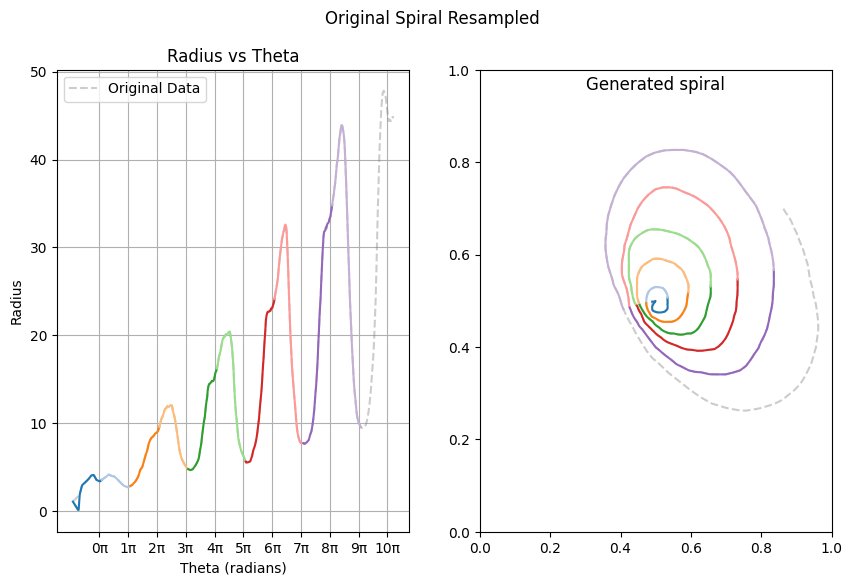

Original spiral points: 465
Reconstructed spiral points: 556


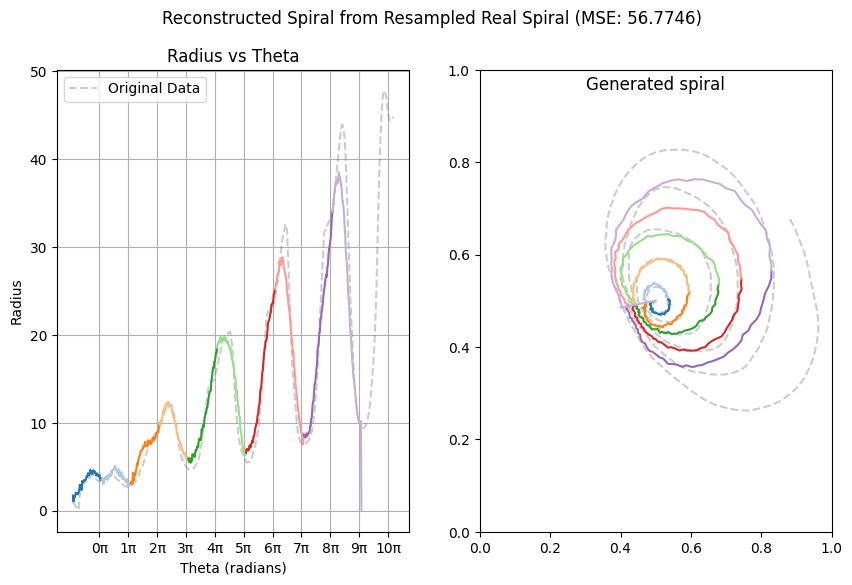

Reconstructed spiral points: 465


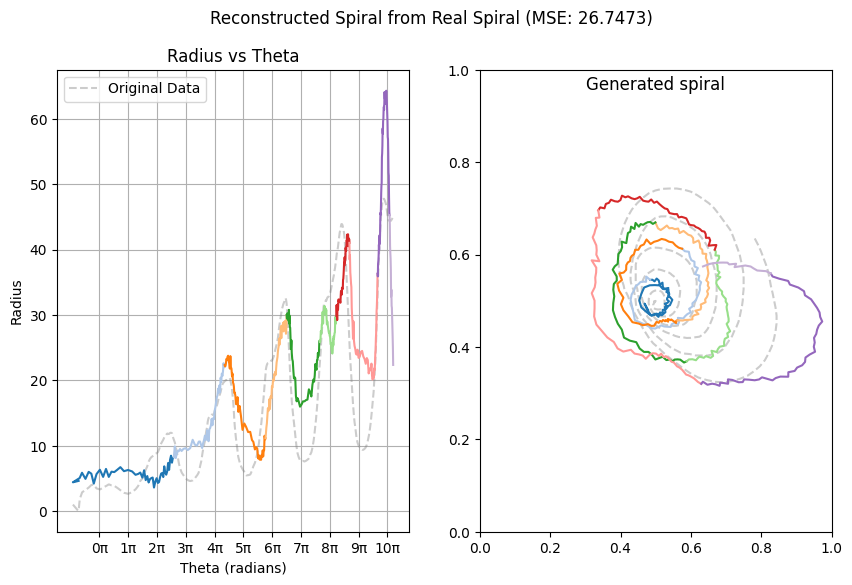

In [9]:
# directory = "drawings/nice_samples/"
# filename = "spirala_partially_flat"
directory = "drawings/long/"
filename = "l_tight1"
filepath = directory + filename + ".csv"

descriptors = get_descriptors(filepath, M=500)
g_recon = np.array(list(inverse_fourier_descriptor_transform(descriptors).values()))
sp_x, sp_y = remove_end_line(g_recon[:,0], g_recon[:,1])
sp_r = np.sqrt(sp_x**2 + sp_y**2) / 3
sp_theta = np.arctan2(sp_y, sp_x)
sp_theta = np.unwrap(sp_theta)
if np.mean(sp_theta) < 0:
    sp_theta *= -1

sp_resampled_r, sp_resampled_theta = resample_by_nearest_linear(sp_r, sp_theta, step=(2*np.pi/100), allow_extrapolate=False)

ax1, ax2 = plot_segmented_spiral(
    gen_theta=sp_resampled_theta,
    gen_r=sp_resampled_r,
    num_segments=10,
    figsize=(10,6),
    plot_title="Original Spiral Resampled",
    original_data=(sp_theta, sp_r)
)

print(f"Original spiral points: {len(sp_r)}")

temp_df = pd.DataFrame({'r': sp_resampled_r, 'theta': sp_resampled_theta})
temp_df.to_csv("temp_results/temp_spiral.csv", index=False)
test_dataset = SpiralDataset("temp_results", preload=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, collate_fn=collate_pad_fixed)

recon_rs, recon_thetas, losses = plot_spiral_reconstruction(loaded_model, test_loader, 'cpu', num_samples=1, plot=False)

print(f"Reconstructed spiral points: {len(recon_rs[0])}")

idx2plot = 0
ax1, ax2 = plot_segmented_spiral(
    gen_theta=recon_thetas[idx2plot],
    gen_r=recon_rs[idx2plot],
    num_segments=10,
    figsize=(10,6),
    plot_title=f"Reconstructed Spiral from Resampled Real Spiral (MSE: {losses[idx2plot]:.4f})",
    original_data=(sp_resampled_theta, sp_resampled_r)
)

temp_df = pd.DataFrame({'r': sp_r, 'theta': sp_theta})
temp_df.to_csv("temp_results/temp_spiral.csv", index=False)
test_dataset = SpiralDataset("temp_results", preload=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, collate_fn=collate_pad_fixed)

recon_rs, recon_thetas, losses = plot_spiral_reconstruction(loaded_model, test_loader, 'cpu', num_samples=1, plot=False)

print(f"Reconstructed spiral points: {len(recon_rs[0])}")

idx2plot = 0
ax1, ax2 = plot_segmented_spiral(
    gen_theta=recon_thetas[idx2plot],
    gen_r=recon_rs[idx2plot],
    num_segments=10,
    figsize=(10,6),
    plot_title=f"Reconstructed Spiral from Real Spiral (MSE: {losses[idx2plot]:.4f})",
    original_data=(sp_resampled_theta, sp_resampled_r)
)

# Parallel coordinate system of latent space

In [11]:
import random
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

In [62]:
latent_dim = 16
num_classes = 4
samples_per_class = 50

syn_data = {} # key: class, value: array of samples

for i in range(num_classes):
    syn_data[i] = []
    normal_params = []
    for _ in range(latent_dim):
        mean = random.uniform(-1, 1)
        var = random.uniform(0,0.4)
        normal_params.append((mean,var))
    for _ in range(samples_per_class):
        temp_vec = []
        for normal in normal_params:
            value = np.random.normal(normal[0], normal[1])
            temp_vec.append(value)
        syn_data[i].append(temp_vec)

In [63]:
CLASS_NAMES = ["Archimedes", "Flat", "Tight", "Spiky"]
COLORS = ["red", "blue", "green", "purple"]
## ===================================================================

data = np.array([np.array(syn_data[c]) for c in range(num_classes)])  

In [64]:
COLORS = ["red", "blue", "green", "purple"]

def plot_latent_distributions(data, colors, class_names, title="Class distributions per latent dimension"):
    """
    Plot distributions of latent dimensions per class.

    Parameters
    ----------
    data : np.ndarray
        Array of shape (num_classes, samples_per_class, latent_dim)
    colors : list of str
        List of colors for each class
    class_names : dict
        Dictionary mapping class to it's name
    title : str
        Plot title
    """
    num_classes, _, latent_dim = data.shape
    fig, ax = plt.subplots(figsize=(14, 6))
    x_positions = np.arange(latent_dim)

    for dim in range(latent_dim):
        for cls in range(num_classes):
            values = data[cls, :, dim]

            # KDE for smooth distribution
            kde = gaussian_kde(values)
            y = np.linspace(values.min() - 0.2, values.max() + 0.2, 300)
            density = kde(y)

            # Normalize horizontal width
            density = density / density.max() * 0.3  

            # Offset for class
            offset = (cls - num_classes/2) * 0.06

            ax.fill_betweenx(
                y,
                x_positions[dim] + offset,
                x_positions[dim] + offset + density,
                color=colors[cls],
                alpha=0.4,
                linewidth=0
            )

    # Formatting
    ax.set_xticks(x_positions)
    ax.set_xlabel("Latent dimension")
    ax.set_ylabel("Value")
    ax.set_title(title)
    ax.grid(axis="y", alpha=0.2)

    # Legend
    for cls in range(num_classes):
        ax.fill_between([], [], [], color=colors[cls], alpha=0.4, label=f"{class_names[cls]}")
    ax.legend(title="Classes")

    plt.tight_layout()
    plt.show()

In [69]:


def plot_latent_distributions(data, colors, class_names, title="Class distributions per latent dimension"):
    """
    Plot distributions of latent dimensions per class using KDEs,
    with mean values connected by lines per class.

    Parameters
    ----------
    data : np.ndarray
        Array of shape (num_classes, samples_per_class, latent_dim)
    colors : list of str
        List of colors for each class
    class_names : list of str
        List of class names, order must match the first axis of data
    title : str
        Plot title
    """
    num_classes, _, latent_dim = data.shape
    fig, ax = plt.subplots(figsize=(14, 6))
    x_positions = np.arange(latent_dim)

    for dim in range(latent_dim):
        for cls in range(num_classes):
            values = data[cls, :, dim]

            # KDE for smooth distribution
            kde = gaussian_kde(values)
            y = np.linspace(values.min() - 0.2, values.max() + 0.2, 300)
            density = kde(y)

            # Normalize horizontal width
            density = density / density.max() * 0.3  

            # Offset for class
            offset = (cls - num_classes/2) * 0.06

            ax.fill_betweenx(
                y,
                x_positions[dim] ,#+ offset,
                x_positions[dim]+density, #+ offset + density,
                color=colors[cls],
                alpha=0.4,
                linewidth=0
            )

    # Plot mean values connected with lines per class
    for cls in range(num_classes):
        means = data[cls].mean(axis=0)  # mean over samples for each latent dim
        ax.plot(x_positions, means, color=colors[cls], marker='o', linestyle='-', linewidth=2, markersize=6, alpha=0.4)

    # Formatting
    ax.set_xticks(x_positions)
    ax.set_xticklabels([f"dim {i}" for i in range(latent_dim)])
    ax.set_xlabel("Latent dimension")
    ax.set_ylabel("Value")
    ax.set_title(title)
    ax.grid(axis="y", alpha=0.2)

    # Legend with class names
    for cls in range(num_classes):
        ax.fill_between([], [], [], color=colors[cls], alpha=0.4, label=class_names[cls])
    ax.legend(title="Classes")

    plt.tight_layout()
    plt.show()

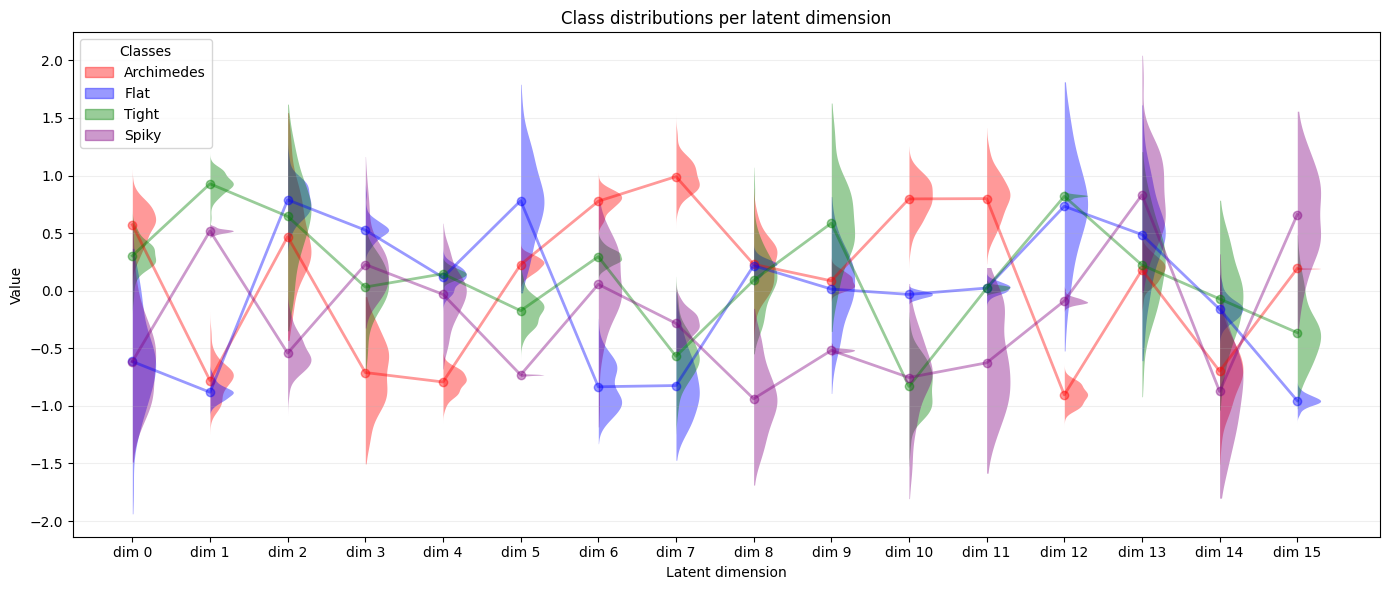

In [70]:
plot_latent_distributions(data, COLORS, CLASS_NAMES)